**Xây dựng Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/deeplearning/datafordoan.zip -d .

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: ./datafordemo/test/bike/022.jpg  
  inflating: ./datafordemo/test/bike/023.jpg  
  inflating: ./datafordemo/test/bike/024.jpg  
  inflating: ./datafordemo/test/bike/025.jpg  
  inflating: ./datafordemo/test/bike/026.jpg  
  inflating: ./datafordemo/test/bike/027.jpg  
  inflating: ./datafordemo/test/bike/028.jpg  
  inflating: ./datafordemo/test/bike/029.jpg  
  inflating: ./datafordemo/test/bike/030.jpg  
  inflating: ./datafordemo/test/bike/031.jpg  
  inflating: ./datafordemo/test/bike/032.jpg  
  inflating: ./datafordemo/test/bike/033.jpg  
  inflating: ./datafordemo/test/bike/034.jpg  
  inflating: ./datafordemo/test/bike/035.jpg  
  inflating: ./datafordemo/test/bike/036.jpg  
  inflating: ./datafordemo/test/bike/037.jpg  
  inflating: ./datafordemo/test/bike/038.jpg  
  inflating: ./datafordemo/test/bike/039.jpg  
  inflating: ./datafordemo/test/bike/040.jpg  
  inflating: ./datafordemo/test/bike/041.jpg  
  i

In [ ]:
import numpy as np
import progressbar
import imutils
import random
import cv2
import os
from pathlib import Path

In [13]:
def create_dataset():
    DATASET_BASE = Path('/content/datafordemo')

    # 1. Lấy đường dẫn tập tin
    image_paths = []
    for root, dirs, files in os.walk(DATASET_BASE / 'train'):
        for file in files:
            image_paths.append(os.path.join(root, file))

    # 2. Chọn 3500 hình ảnh trong tệp train
    random.shuffle(image_paths)
    image_paths = image_paths[:3500]

    # 3. Xoay hình ảnh
    angles = {0: 0,
              90: 0,
              180: 0,
              270: 0}

    # Bắt đầu xử lý
    bar = progressbar.ProgressBar(maxval=len(image_paths))
    bar.start()

    for i, image_path in enumerate(image_paths):
        image = cv2.imread(image_path)
        angle = np.random.choice(list(angles.keys()))

        if image is None:
            continue

        # Xoay ảnh
        image = imutils.rotate_bound(image, angle)

        # Đường dẫn đầu ra
        base = os.path.sep.join([str(DATASET_BASE / 'rotated_images'), str(angle)])
        if not os.path.exists(base):
            os.makedirs(base)

        index = image_path.rfind(".")
        ext = image_path[index:]
        output_path = [base, "image_{}{}".format(str(angles.get(angle, 0)).zfill(5), ext)]
        output_path = os.path.sep.join(output_path)

        # Viết tập tin
        cv2.imwrite(output_path, image)

        angles[angle] = angles.get(angle, 0) + 1
        bar.update(i)

    bar.finish()

    for angle in list(angles.keys()):
        print('Số lượng ảnh góc {}: {}'.format(angle, angles[angle]))

In [14]:
create_dataset()

100% (3500 of 3500) |####################| Elapsed Time: 0:01:11 Time:  0:01:11


Số lượng ảnh góc 0: 849
Số lượng ảnh góc 90: 903
Số lượng ảnh góc 180: 897
Số lượng ảnh góc 270: 851


**Feature extraction**

In [15]:
import h5py
import os


class HDF5DatasetWriter:
    def __init__(self, dims, outputPath, dataKey='images', bufSize=1000):
        '''
        check to see if the output path exists, and if so, raise an exception
        '''
        if os.path.exists(outputPath):
            raise ValueError("The supplied 'output path' already exists and cannot be overwritten. Manually delete the file before contuinuing", outputPath)

        # mở cơ sở dữ liệu HDF5 để ghi và tạo 2 bộ dữ liệu: một để lưu trữ hình ảnh/đối tượng địa lý và một để lưu trữ nhãn lớp
        self.db = h5py.File(outputPath, 'w')
        self.data = self.db.create_dataset(dataKey, dims, "float")
        self.labels = self.db.create_dataset('labels', (dims[0],), int)

        # Lưu trữ kích thước bộ đệm, sau đó khởi tạo đệm chính nó cùng với chỉ số vào kho dữ liệu
        self.bufSize = bufSize
        self.buffer = {'data': [], 'labels': []}
        self.idx = 0

    def add(self, rows, labels):
        '''
        add the rows and labels to the buffer
        '''
        self.buffer['data'].extend(rows)
        self.buffer['labels'].extend(labels)

        # kiểm tra xem bộ đệm có cần được chuyển vào đĩa không
        if len(self.buffer['data']) >= self.bufSize:
            self.flush()

    def flush(self):
        '''
        write the buffers to disk then reset the buffer
        '''
        i = self.idx + len(self.buffer['data'])
        self.data[self.idx:i] = self.buffer['data']
        self.labels[self.idx:i] = self.buffer['labels']
        self.idx = i
        self.buffer = {'data': [], 'labels': []}

    def storeClassLabels(self, classLabels):
        '''
        create a dataset to store the actual class label names, then store the class labels
        '''
        dt = h5py.special_dtype(vlen=str)
        labelSet = self.db.create_dataset('label_names', (len(classLabels),), dtype=dt)
        labelSet[:] = classLabels

    def close(self):
        '''
        check to see if ther is any other entries in the buffer that need to be flushed to the disk
        '''
        if len(self.buffer['data']) > 0:
            self.flush()

        # đóng tập dữ liệu
        self.db.close()

In [16]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
import numpy as np
import progressbar
import random
import os
from pathlib import Path

def feature_extraction():
    DATASET_BASE = Path('/content/datafordemo/rotated_images')
    OUTPUT_PATH = Path('/content/datafordemo/hdf5/features.hdf5')

    # 1. Nhận đường dẫn của hình ảnh được xoay và nhãn của chúng
    image_paths = []
    labels = []
    for angle_dir in DATASET_BASE.iterdir():
        for image_file in angle_dir.iterdir():
          image_paths.append(str(image_file))
          labels.append(angle_dir.name)
    # 2. Mã hóa nhãn thành số
    le = LabelEncoder()
    labels = le.fit_transform(labels)

    # 3. Tải mô hình VGG16, ngoại trừ lớp trên cùng (các lớp được kết nối đầy đủ)
    base_model = VGG16(weights="imagenet", include_top=False)
    model = Model(inputs=base_model.input, outputs=base_model.output)

    # 4. Tạo cơ sở dữ liệu HDF5
    import os

    output_directory = '/content/datafordemo/hdf5/'
    if not os.path.exists(output_directory):
       os.makedirs(output_directory)
    dims = (len(image_paths), 512 * 7 * 7)  # Giả sử đầu ra từ VGG16 'include_top=False' là 7x7x512
    writer = HDF5DatasetWriter(dims, str(OUTPUT_PATH), dataKey='features', bufSize=1000)

    # 5. Lưu tên nhãn vào tập dữ liệu
    writer.storeClassLabels(le.classes_)

    # 6. Lặp lại theo đợt
    BATCH_SIZE = 32
    bar = progressbar.ProgressBar(maxval=len(image_paths))
    bar.start()

    for i in range(0, len(image_paths), BATCH_SIZE):
        batch_paths = image_paths[i:i + BATCH_SIZE]
        batch_labels = labels[i:i + BATCH_SIZE]
        batch_images = []


        for image_path in batch_paths:
            image = load_img(image_path, target_size=(224, 224))
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)

            batch_images.append(image)


        batch_images = np.vstack(batch_images)
        features = model.predict(batch_images, batch_size=BATCH_SIZE)

        features = features.reshape((features.shape[0], 512 * 7 * 7))
        writer.add(features, batch_labels)
        bar.update(i)

    bar.finish()
    writer.close()
feature_extraction()

58889256/58889256 [==============================] - 4s 0us/step


  0% (0 of 3940) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

1/1 [==============================] - 8s 8s/step


  0% (0 of 3940) |                       | Elapsed Time: 0:00:07 ETA:  --:--:--

1/1 [==============================] - 0s 34ms/step


  0% (32 of 3940) |                      | Elapsed Time: 0:00:08 ETA:   0:16:50

1/1 [==============================] - 0s 36ms/step


  1% (64 of 3940) |                      | Elapsed Time: 0:00:08 ETA:   0:08:39

1/1 [==============================] - 0s 37ms/step


  2% (96 of 3940) |                      | Elapsed Time: 0:00:08 ETA:   0:05:54

1/1 [==============================] - 0s 40ms/step


  3% (128 of 3940) |                     | Elapsed Time: 0:00:09 ETA:   0:04:33

1/1 [==============================] - 0s 34ms/step


  4% (160 of 3940) |                     | Elapsed Time: 0:00:09 ETA:   0:03:43

1/1 [==============================] - 0s 36ms/step


  4% (192 of 3940) |#                    | Elapsed Time: 0:00:09 ETA:   0:03:10

1/1 [==============================] - 0s 36ms/step


  5% (224 of 3940) |#                    | Elapsed Time: 0:00:10 ETA:   0:00:36

1/1 [==============================] - 0s 36ms/step


  6% (256 of 3940) |#                    | Elapsed Time: 0:00:10 ETA:   0:00:35

1/1 [==============================] - 0s 33ms/step


  7% (288 of 3940) |#                    | Elapsed Time: 0:00:10 ETA:   0:00:35

1/1 [==============================] - 0s 34ms/step


  8% (320 of 3940) |#                    | Elapsed Time: 0:00:11 ETA:   0:00:35

1/1 [==============================] - 0s 29ms/step


  8% (352 of 3940) |#                    | Elapsed Time: 0:00:11 ETA:   0:00:34

1/1 [==============================] - 0s 35ms/step


  9% (384 of 3940) |##                   | Elapsed Time: 0:00:11 ETA:   0:00:38

1/1 [==============================] - 0s 27ms/step


 10% (416 of 3940) |##                   | Elapsed Time: 0:00:12 ETA:   0:00:37

1/1 [==============================] - 0s 33ms/step


 11% (448 of 3940) |##                   | Elapsed Time: 0:00:12 ETA:   0:00:37

1/1 [==============================] - 0s 34ms/step


 12% (480 of 3940) |##                   | Elapsed Time: 0:00:12 ETA:   0:00:36

1/1 [==============================] - 0s 34ms/step


 12% (512 of 3940) |##                   | Elapsed Time: 0:00:13 ETA:   0:00:37

1/1 [==============================] - 0s 27ms/step


 13% (544 of 3940) |##                   | Elapsed Time: 0:00:13 ETA:   0:00:36

1/1 [==============================] - 0s 25ms/step


 14% (576 of 3940) |###                  | Elapsed Time: 0:00:13 ETA:   0:00:35

1/1 [==============================] - 0s 26ms/step


 15% (608 of 3940) |###                  | Elapsed Time: 0:00:14 ETA:   0:00:33

1/1 [==============================] - 0s 27ms/step


 16% (640 of 3940) |###                  | Elapsed Time: 0:00:14 ETA:   0:00:32

1/1 [==============================] - 0s 26ms/step


 17% (672 of 3940) |###                  | Elapsed Time: 0:00:14 ETA:   0:00:32

1/1 [==============================] - 0s 38ms/step


 17% (704 of 3940) |###                  | Elapsed Time: 0:00:15 ETA:   0:00:32

1/1 [==============================] - 0s 25ms/step


 18% (736 of 3940) |###                  | Elapsed Time: 0:00:15 ETA:   0:00:33

1/1 [==============================] - 0s 54ms/step


 19% (768 of 3940) |####                 | Elapsed Time: 0:00:15 ETA:   0:00:35

1/1 [==============================] - 0s 45ms/step


 20% (800 of 3940) |####                 | Elapsed Time: 0:00:16 ETA:   0:00:36

1/1 [==============================] - 0s 36ms/step


 21% (832 of 3940) |####                 | Elapsed Time: 0:00:16 ETA:   0:00:40

1/1 [==============================] - 0s 44ms/step


 21% (864 of 3940) |####                 | Elapsed Time: 0:00:17 ETA:   0:00:41

1/1 [==============================] - 0s 34ms/step


 22% (896 of 3940) |####                 | Elapsed Time: 0:00:17 ETA:   0:00:40

1/1 [==============================] - 0s 40ms/step


 23% (928 of 3940) |####                 | Elapsed Time: 0:00:18 ETA:   0:00:40

1/1 [==============================] - 0s 38ms/step


 24% (960 of 3940) |#####                | Elapsed Time: 0:00:18 ETA:   0:00:38

1/1 [==============================] - 0s 42ms/step


 25% (992 of 3940) |#####                | Elapsed Time: 0:00:19 ETA:   0:00:49

1/1 [==============================] - 0s 28ms/step


 25% (1024 of 3940) |#####               | Elapsed Time: 0:00:19 ETA:   0:00:47

1/1 [==============================] - 0s 28ms/step


 26% (1056 of 3940) |#####               | Elapsed Time: 0:00:19 ETA:   0:00:43

1/1 [==============================] - 0s 26ms/step


 27% (1088 of 3940) |#####               | Elapsed Time: 0:00:20 ETA:   0:00:46

1/1 [==============================] - 0s 26ms/step


 28% (1120 of 3940) |#####               | Elapsed Time: 0:00:20 ETA:   0:00:42

1/1 [==============================] - 0s 25ms/step


 29% (1152 of 3940) |#####               | Elapsed Time: 0:00:21 ETA:   0:00:39

1/1 [==============================] - 0s 25ms/step


 30% (1184 of 3940) |######              | Elapsed Time: 0:00:21 ETA:   0:00:30

1/1 [==============================] - 0s 34ms/step


 30% (1216 of 3940) |######              | Elapsed Time: 0:00:21 ETA:   0:00:29

1/1 [==============================] - 0s 26ms/step


 31% (1248 of 3940) |######              | Elapsed Time: 0:00:22 ETA:   0:00:29

1/1 [==============================] - 0s 26ms/step


 32% (1280 of 3940) |######              | Elapsed Time: 0:00:22 ETA:   0:00:28

1/1 [==============================] - 0s 35ms/step


 33% (1312 of 3940) |######              | Elapsed Time: 0:00:22 ETA:   0:00:25

1/1 [==============================] - 0s 26ms/step


 34% (1344 of 3940) |######              | Elapsed Time: 0:00:22 ETA:   0:00:25

1/1 [==============================] - 0s 26ms/step


 34% (1376 of 3940) |######              | Elapsed Time: 0:00:23 ETA:   0:00:24

1/1 [==============================] - 0s 27ms/step


 35% (1408 of 3940) |#######             | Elapsed Time: 0:00:23 ETA:   0:00:24

1/1 [==============================] - 0s 28ms/step


 36% (1440 of 3940) |#######             | Elapsed Time: 0:00:23 ETA:   0:00:23

1/1 [==============================] - 0s 27ms/step


 37% (1472 of 3940) |#######             | Elapsed Time: 0:00:24 ETA:   0:00:23

1/1 [==============================] - 0s 27ms/step


 38% (1504 of 3940) |#######             | Elapsed Time: 0:00:24 ETA:   0:00:23

1/1 [==============================] - 0s 26ms/step


 38% (1536 of 3940) |#######             | Elapsed Time: 0:00:24 ETA:   0:00:22

1/1 [==============================] - 0s 25ms/step


 39% (1568 of 3940) |#######             | Elapsed Time: 0:00:25 ETA:   0:00:22

1/1 [==============================] - 0s 25ms/step


 40% (1600 of 3940) |########            | Elapsed Time: 0:00:25 ETA:   0:00:22

1/1 [==============================] - 0s 25ms/step


 41% (1632 of 3940) |########            | Elapsed Time: 0:00:25 ETA:   0:00:22

1/1 [==============================] - 0s 28ms/step


 42% (1664 of 3940) |########            | Elapsed Time: 0:00:26 ETA:   0:00:21

1/1 [==============================] - 0s 25ms/step


 43% (1696 of 3940) |########            | Elapsed Time: 0:00:26 ETA:   0:00:21

1/1 [==============================] - 0s 25ms/step


 43% (1728 of 3940) |########            | Elapsed Time: 0:00:26 ETA:   0:00:21

1/1 [==============================] - 0s 26ms/step


 44% (1760 of 3940) |########            | Elapsed Time: 0:00:26 ETA:   0:00:20

1/1 [==============================] - 0s 26ms/step


 45% (1792 of 3940) |#########           | Elapsed Time: 0:00:27 ETA:   0:00:20

1/1 [==============================] - 0s 27ms/step


 46% (1824 of 3940) |#########           | Elapsed Time: 0:00:27 ETA:   0:00:20

1/1 [==============================] - 0s 76ms/step


 47% (1856 of 3940) |#########           | Elapsed Time: 0:00:27 ETA:   0:00:20

1/1 [==============================] - 0s 29ms/step


 47% (1888 of 3940) |#########           | Elapsed Time: 0:00:28 ETA:   0:00:20

1/1 [==============================] - 0s 27ms/step


 48% (1920 of 3940) |#########           | Elapsed Time: 0:00:28 ETA:   0:00:19

1/1 [==============================] - 0s 32ms/step


 49% (1952 of 3940) |#########           | Elapsed Time: 0:00:28 ETA:   0:00:21

1/1 [==============================] - 0s 35ms/step


 50% (1984 of 3940) |##########          | Elapsed Time: 0:00:29 ETA:   0:00:22

1/1 [==============================] - 0s 38ms/step


 51% (2016 of 3940) |##########          | Elapsed Time: 0:00:30 ETA:   0:00:31

1/1 [==============================] - 0s 39ms/step


 51% (2048 of 3940) |##########          | Elapsed Time: 0:00:30 ETA:   0:00:33

1/1 [==============================] - 0s 42ms/step


 52% (2080 of 3940) |##########          | Elapsed Time: 0:00:31 ETA:   0:00:32

1/1 [==============================] - 0s 39ms/step


 53% (2112 of 3940) |##########          | Elapsed Time: 0:00:31 ETA:   0:00:31

1/1 [==============================] - 0s 31ms/step


 54% (2144 of 3940) |##########          | Elapsed Time: 0:00:31 ETA:   0:00:29

1/1 [==============================] - 0s 24ms/step


 55% (2176 of 3940) |###########         | Elapsed Time: 0:00:32 ETA:   0:00:26

1/1 [==============================] - 0s 26ms/step


 56% (2208 of 3940) |###########         | Elapsed Time: 0:00:32 ETA:   0:00:20

1/1 [==============================] - 0s 26ms/step


 56% (2240 of 3940) |###########         | Elapsed Time: 0:00:32 ETA:   0:00:18

1/1 [==============================] - 0s 26ms/step


 57% (2272 of 3940) |###########         | Elapsed Time: 0:00:33 ETA:   0:00:17

1/1 [==============================] - 0s 26ms/step


 58% (2304 of 3940) |###########         | Elapsed Time: 0:00:33 ETA:   0:00:17

1/1 [==============================] - 0s 32ms/step


 59% (2336 of 3940) |###########         | Elapsed Time: 0:00:33 ETA:   0:00:16

1/1 [==============================] - 0s 25ms/step


 60% (2368 of 3940) |############        | Elapsed Time: 0:00:34 ETA:   0:00:14

1/1 [==============================] - 0s 25ms/step


 60% (2400 of 3940) |############        | Elapsed Time: 0:00:34 ETA:   0:00:14

1/1 [==============================] - 0s 27ms/step


 61% (2432 of 3940) |############        | Elapsed Time: 0:00:34 ETA:   0:00:13

1/1 [==============================] - 0s 27ms/step


 62% (2464 of 3940) |############        | Elapsed Time: 0:00:34 ETA:   0:00:13

1/1 [==============================] - 0s 25ms/step


 63% (2496 of 3940) |############        | Elapsed Time: 0:00:35 ETA:   0:00:13

1/1 [==============================] - 0s 25ms/step


 64% (2528 of 3940) |############        | Elapsed Time: 0:00:35 ETA:   0:00:12

1/1 [==============================] - 0s 25ms/step


 64% (2560 of 3940) |############        | Elapsed Time: 0:00:35 ETA:   0:00:12

1/1 [==============================] - 0s 27ms/step


 65% (2592 of 3940) |#############       | Elapsed Time: 0:00:36 ETA:   0:00:12

1/1 [==============================] - 0s 25ms/step


 66% (2624 of 3940) |#############       | Elapsed Time: 0:00:36 ETA:   0:00:12

1/1 [==============================] - 0s 30ms/step


 67% (2656 of 3940) |#############       | Elapsed Time: 0:00:36 ETA:   0:00:11

1/1 [==============================] - 0s 27ms/step


 68% (2688 of 3940) |#############       | Elapsed Time: 0:00:37 ETA:   0:00:11

1/1 [==============================] - 0s 27ms/step


 69% (2720 of 3940) |#############       | Elapsed Time: 0:00:37 ETA:   0:00:11

1/1 [==============================] - 0s 26ms/step


 69% (2752 of 3940) |#############       | Elapsed Time: 0:00:37 ETA:   0:00:11

1/1 [==============================] - 0s 27ms/step


 70% (2784 of 3940) |##############      | Elapsed Time: 0:00:37 ETA:   0:00:11

1/1 [==============================] - 0s 26ms/step


 71% (2816 of 3940) |##############      | Elapsed Time: 0:00:38 ETA:   0:00:10

1/1 [==============================] - 0s 37ms/step


 72% (2848 of 3940) |##############      | Elapsed Time: 0:00:38 ETA:   0:00:10

1/1 [==============================] - 0s 30ms/step


 73% (2880 of 3940) |##############      | Elapsed Time: 0:00:38 ETA:   0:00:10

1/1 [==============================] - 0s 26ms/step


 73% (2912 of 3940) |##############      | Elapsed Time: 0:00:39 ETA:   0:00:09

1/1 [==============================] - 0s 27ms/step


 74% (2944 of 3940) |##############      | Elapsed Time: 0:00:39 ETA:   0:00:09

1/1 [==============================] - 0s 27ms/step


 75% (2976 of 3940) |###############     | Elapsed Time: 0:00:39 ETA:   0:00:09

1/1 [==============================] - 0s 35ms/step


 76% (3008 of 3940) |###############     | Elapsed Time: 0:00:40 ETA:   0:00:08

1/1 [==============================] - 0s 26ms/step


 77% (3040 of 3940) |###############     | Elapsed Time: 0:00:40 ETA:   0:00:11

1/1 [==============================] - 0s 26ms/step


 77% (3072 of 3940) |###############     | Elapsed Time: 0:00:41 ETA:   0:00:11

1/1 [==============================] - 0s 27ms/step


 78% (3104 of 3940) |###############     | Elapsed Time: 0:00:41 ETA:   0:00:10

1/1 [==============================] - 0s 26ms/step


 79% (3136 of 3940) |###############     | Elapsed Time: 0:00:41 ETA:   0:00:10

1/1 [==============================] - 0s 36ms/step


 80% (3168 of 3940) |################    | Elapsed Time: 0:00:42 ETA:   0:00:10

1/1 [==============================] - 0s 34ms/step


 81% (3200 of 3940) |################    | Elapsed Time: 0:00:42 ETA:   0:00:09

1/1 [==============================] - 0s 42ms/step


 82% (3232 of 3940) |################    | Elapsed Time: 0:00:43 ETA:   0:00:07

1/1 [==============================] - 0s 33ms/step


 82% (3264 of 3940) |################    | Elapsed Time: 0:00:43 ETA:   0:00:07

1/1 [==============================] - 0s 39ms/step


 83% (3296 of 3940) |################    | Elapsed Time: 0:00:43 ETA:   0:00:07

1/1 [==============================] - 0s 38ms/step


 84% (3328 of 3940) |################    | Elapsed Time: 0:00:44 ETA:   0:00:07

1/1 [==============================] - 0s 42ms/step


 85% (3360 of 3940) |#################   | Elapsed Time: 0:00:44 ETA:   0:00:07

1/1 [==============================] - 0s 35ms/step


 86% (3392 of 3940) |#################   | Elapsed Time: 0:00:45 ETA:   0:00:06

1/1 [==============================] - 0s 25ms/step


 86% (3424 of 3940) |#################   | Elapsed Time: 0:00:45 ETA:   0:00:06

1/1 [==============================] - 0s 26ms/step


 87% (3456 of 3940) |#################   | Elapsed Time: 0:00:45 ETA:   0:00:05

1/1 [==============================] - 0s 24ms/step


 88% (3488 of 3940) |#################   | Elapsed Time: 0:00:45 ETA:   0:00:04

1/1 [==============================] - 0s 26ms/step


 89% (3520 of 3940) |#################   | Elapsed Time: 0:00:46 ETA:   0:00:04

1/1 [==============================] - 0s 28ms/step


 90% (3552 of 3940) |##################  | Elapsed Time: 0:00:46 ETA:   0:00:03

1/1 [==============================] - 0s 26ms/step


 90% (3584 of 3940) |##################  | Elapsed Time: 0:00:46 ETA:   0:00:03

1/1 [==============================] - 0s 26ms/step


 91% (3616 of 3940) |##################  | Elapsed Time: 0:00:47 ETA:   0:00:02

1/1 [==============================] - 0s 28ms/step


 92% (3648 of 3940) |##################  | Elapsed Time: 0:00:47 ETA:   0:00:02

1/1 [==============================] - 0s 26ms/step


 93% (3680 of 3940) |##################  | Elapsed Time: 0:00:47 ETA:   0:00:02

1/1 [==============================] - 0s 26ms/step


 94% (3712 of 3940) |##################  | Elapsed Time: 0:00:47 ETA:   0:00:02

1/1 [==============================] - 0s 30ms/step


 95% (3744 of 3940) |################### | Elapsed Time: 0:00:48 ETA:   0:00:01

1/1 [==============================] - 0s 25ms/step


 95% (3776 of 3940) |################### | Elapsed Time: 0:00:48 ETA:   0:00:01

1/1 [==============================] - 0s 27ms/step


 96% (3808 of 3940) |################### | Elapsed Time: 0:00:48 ETA:   0:00:01

1/1 [==============================] - 0s 33ms/step


 97% (3840 of 3940) |################### | Elapsed Time: 0:00:49 ETA:   0:00:00

1/1 [==============================] - 0s 26ms/step


 98% (3872 of 3940) |################### | Elapsed Time: 0:00:49 ETA:   0:00:00

1/1 [==============================] - 0s 27ms/step


 99% (3904 of 3940) |################### | Elapsed Time: 0:00:49 ETA:   0:00:00

1/1 [==============================] - 2s 2s/step


100% (3940 of 3940) |####################| Elapsed Time: 0:00:51 Time:  0:00:51


**Xây dựng và Huấn luyện mô hình**

In [17]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import h5py

def train_model():
    # 1. Tải dữ liệu từ tệp HDF5
    hdf5_path = '/content/datafordemo/hdf5/features.hdf5'  # Đường dẫn đến tệp HDF5
    with h5py.File(hdf5_path, 'r') as f:
        features = np.array(f['features'])
        labels = np.array(f['labels'])

    # Chia dữ liệu thành tập huấn luyện và xác nhận
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

    # 2. Build model
    model = Sequential([
        Flatten(input_shape=(512 * 7 * 7,)),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(np.unique(labels)), activation='softmax')
    ])

    # 3. Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # 4. Xác định gọi lại
    callbacks = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')


    # 5. Train the model
    history = model.fit(X_train,
                        y_train,
                        epochs=50,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=callbacks)


In [18]:
train_model()

Epoch 1/50
99/99 [==============================] - ETA: 0s - loss: 9.2798 - accuracy: 0.4727

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


99/99 [==============================] - 9s 27ms/step - loss: 9.2798 - accuracy: 0.4727 - val_loss: 0.9238 - val_accuracy: 0.8033
Epoch 2/50
99/99 [==============================] - 2s 19ms/step - loss: 2.6307 - accuracy: 0.7256 - val_loss: 0.6446 - val_accuracy: 0.8541
Epoch 3/50
99/99 [==============================] - 5s 51ms/step - loss: 1.5362 - accuracy: 0.8014 - val_loss: 0.6027 - val_accuracy: 0.8693
Epoch 4/50
99/99 [==============================] - 2s 17ms/step - loss: 1.1037 - accuracy: 0.8382 - val_loss: 0.6253 - val_accuracy: 0.8756
Epoch 5/50
99/99 [==============================] - 2s 16ms/step - loss: 0.8602 - accuracy: 0.8734 - val_loss: 0.5623 - val_accuracy: 0.8896
Epoch 6/50
99/99 [==============================] - 2s 17ms/step - loss: 0.6802 - accuracy: 0.8921 - val_loss: 0.5805 - val_accuracy: 0.8972
Epoch 7/50
99/99 [==============================] - 5s 51ms/step - loss: 0.5425 - accuracy: 0.9204 - val_loss: 0.5841 - val_accuracy: 0.9048
Epoch 8/50
99/99 [======

In [23]:
import h5py
from keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import imutils
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from PIL import Image

def valid_model():

    # 1. Load label names trong file hdf5
    hdf5_path='/content/datafordemo/hdf5/features.hdf5'
    with h5py.File(hdf5_path, 'r') as f:
        label_names = list(f['label_names'])

    # 2. Load ảnh
    image_path='/content/datafordemo/rotated_images/180/image_00001.bmp'
    image = load_img(image_path, target_size=(224, 224))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = preprocess_input(image_array)

    # 3. Load mô hình VGG16
    base_model = VGG16(weights="imagenet", include_top=False)
    model = Model(inputs=base_model.input, outputs=base_model.output)

    # 4. Tính feature extraction
    features = model.predict(image_array)
    features_flatten = features.reshape((1, 7 * 7 * 512))
    # 5. Load model
    model_path='/content/best_model.h5'
    trained_model = load_model(model_path)

    # 6. Sử dụng model để dự đoán góc
    prediction = trained_model.predict(features_flatten)
    predicted_angle = label_names[np.argmax(prediction)]
    angle = int(predicted_angle)
    print('Góc quay của ảnh là ',angle)
    # 7. Quay ảnh góc
    rotated_image = image.rotate(angle)
    # 8. Hiện ảnh chưa xoay và đã xoay
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Ảnh gốc')

    plt.subplot(1, 2, 2)
    plt.imshow(rotated_image)
    plt.title('Ảnh sau khi xoay')



1/1 [==============================] - 0s 65ms/step
Góc quay của ảnh là  180


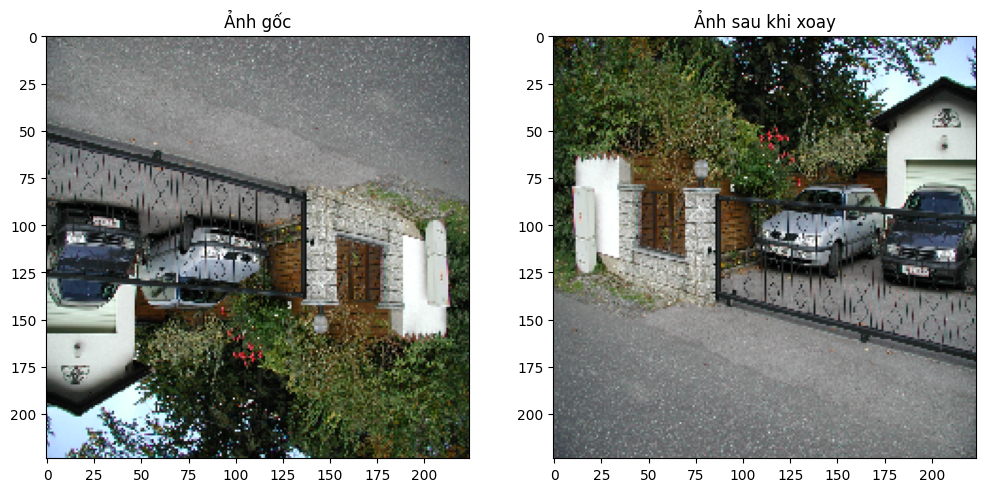

In [24]:
valid_model()